In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [25]:
runlist = np.arange(157, 161, 1)
#runlist = [790, 791, 792]
Loaddir = '../Claudio/Reduced_XANES/'
##############################################3
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 4 runs: [157 158 159 160] from ../Claudio/Reduced_XANES/


## check data files

In [42]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*XANES*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
datafiles    

[157 158 159 160]
32 files found


['../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_energy_eV.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_goodshots1.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_DataDiode1_pump.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_DataDiode1_unpump.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_Pump_probe_Diode1.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_DataDiode2_pump.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_DataDiode2_unpump.npy',
 '../Claudio/Reduced_XANES/run0157-FePhen_RXES_2ps_loop_001/XANES_Pump_probe_Diode2.npy',
 '../Claudio/Reduced_XANES/run0158-FePhen_RXES_2ps_loop_002/XANES_energy_eV.npy',
 '../Claudio/Reduced_XANES/run0158-FePhen_RXES_2ps_loop_002/XANES_goodshots1.npy',
 '../Claudio/Reduced_XANES/run0158-FePhen_RXES_2ps_loop_002/XANES_DataDiode1_pump.npy',
 '../Claudio/Reduced_XANES/run0158-FePhen_RXES

# Plotting XANES  spectra
### load and average data

In [43]:
diode_array = ['XANES_DataDiode1_pump', 'XANES_DataDiode1_unpump', 'XANES_Pump_probe_Diode1',
               'XANES_DataDiode2_pump', 'XANES_DataDiode2_unpump', 'XANES_Pump_probe_Diode2'
              ]

for spec in diode_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    patch = datafiles
    #spec2save = 0
    spec2save = []
    for ff in patch:
        spec2save.append(np.load(ff, allow_pickle=True))
    #spec2save = np.average(temp,axis = 0)
    print (len(patch), spec, np.shape(spec2save))
    np.save(Loaddir+spec+'_all.npy', spec2save)

4 XANES_DataDiode1_pump (4, 121, 3)
4 XANES_DataDiode1_unpump (4, 121, 3)
4 XANES_Pump_probe_Diode1 (4, 121, 3)
4 XANES_DataDiode2_pump (4, 121, 3)
4 XANES_DataDiode2_unpump (4, 121, 3)
4 XANES_Pump_probe_Diode2 (4, 121, 3)


In [44]:
DataDiode1_pump_all = np.load(Loaddir+'/XANES_DataDiode1_pump_all.npy')
DataDiode1_unpump_all = np.load(Loaddir+'/XANES_DataDiode1_unpump_all.npy')
Pump_probe1_all = np.load(Loaddir+'/XANES_Pump_probe_Diode1_all.npy')
DataDiode2_pump_all = np.load(Loaddir+'/XANES_DataDiode2_pump_all.npy')
DataDiode2_unpump_all = np.load(Loaddir+'/XANES_DataDiode2_unpump_all.npy')
Pump_probe2_all = np.load(Loaddir+'/XANES_Pump_probe_Diode2_all.npy')

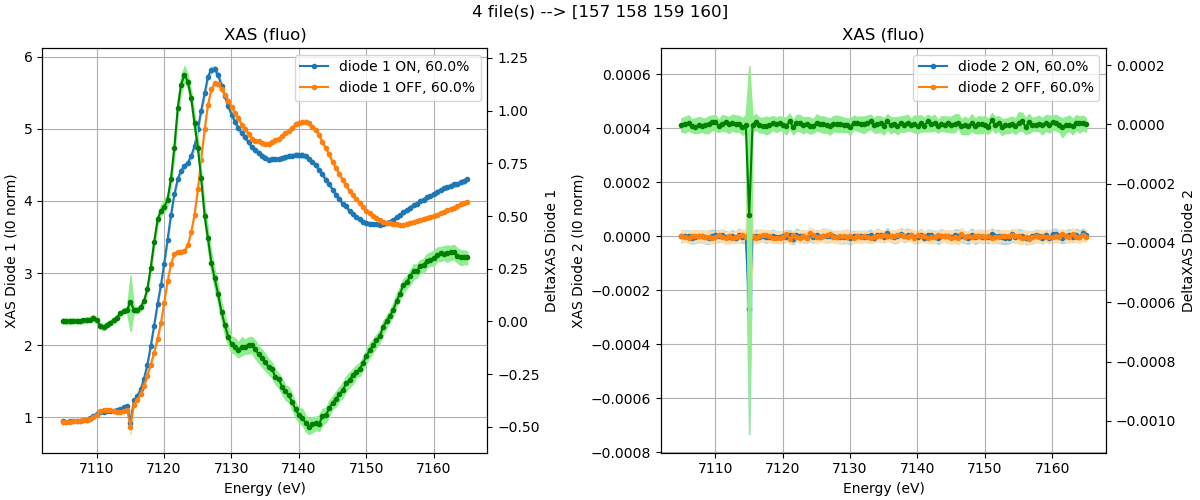

In [47]:
quantile_corr = 0.6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

XAS1_pump = np.mean(DataDiode1_pump_all, axis=0)[:,0]
err1_low_pump = np.mean(DataDiode1_pump_all, axis=0)[:,1]
err1_high_pump = np.mean(DataDiode1_pump_all, axis=0)[:,2]
XAS1_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,0]
err1_low_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,1]
err1_high_unpump = np.mean(DataDiode1_unpump_all, axis =0)[:,2]
XAS1_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,0]
err1_low_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,1]
err1_high_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,2]

XAS2_pump = np.mean(DataDiode2_pump_all, axis=0)[:,0]
err2_low_pump = np.mean(DataDiode2_pump_all, axis=0)[:,1]
err2_high_pump = np.mean(DataDiode2_pump_all, axis=0)[:,2]
XAS2_unpump = np.mean(DataDiode2_unpump_all, axis=0)[:,0]
err2_low_unpump = np.mean(DataDiode2_unpump_all, axis=0)[:,1]
err2_high_unpump = np.mean(DataDiode2_unpump_all, axis =0)[:,2]
XAS2_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,0]
err2_low_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,1]
err2_high_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,2]

ff = glob.glob(Loaddir+'/*{}*/energy_eV.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])


ax3 = ax1.twinx()

ax1.plot(Energy_eV, XAS1_pump, label='diode 1 ON, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS1_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax3.plot(Energy_eV, XAS1_pump_probe, label='diode 1 pp, {}%'.format(quantile_corr*100),marker='.', color='g')
ax3.fill_between(Energy_eV, err1_low_pump_probe, err1_high_pump_probe, color='lightgreen')


ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax4 = ax2.twinx()

ax2.plot(Energy_eV, XAS2_pump, label='diode 2 ON, {}%'.format(quantile_corr*100),marker='.')
ax2.fill_between(Energy_eV, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Energy_eV, XAS2_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),marker='.')
ax2.fill_between(Energy_eV, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax4.plot(Energy_eV, XAS2_pump_probe, label='diode 2 pp, {}%'.format(quantile_corr*100),marker='.', color='g')
ax4.fill_between(Energy_eV, err2_low_pump_probe, err2_high_pump_probe, color='lightgreen')

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("XAS Diode 2 (I0 norm)")
ax4.set_ylabel ("DeltaXAS Diode 2")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

#ax1.legend(loc='best')
#ax2.legend(loc='lower right')
#ax1.set_xlabel('Energy (eV)')
#ax1.set_ylabel('XAS norm')
#ax2.set_ylabel('difference')
#ax1.grid()
plt.show()